# Import lib

In [1]:
import pythonradex

# # import necessary modules
from pythonradex import radiative_transfer, helpers, LAMDA_file, atomic_transition
from scipy import constants
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from tqdm import tqdm
from scipy import constants

from scipy.stats import norm

# Initial setup

In [2]:
# ============================
# (1) Set up the "true" simulation
# ============================

# Path to the molecular data file (CH3OH from the LAMDA database)
datafilepath_methanol = (
    r"C:\Users\alios\OneDrive - University College London\Desktop\UCL\Year3\group project\codes\e_ch3oh.dat"
)
data_methanol = LAMDA_file.read(datafilepath_methanol, read_frequencies=False)

# Geometry and line profile
geometry = "uniform sphere"
line_profile_type = "Gaussian"

# True simulation parameters (using your constants)
N = 1e16 / constants.centi**2  # CH3OH_e column density in m^-2
width_v = 4 * constants.kilo  # line width in m/s (1 km/s * 2)
Tkin = 120  # kinetic temperature in K
LTE_collider_densities_h2only = {"H2": 1e8 / constants.centi**3}  # collider density in m^-3
T_dust = 0
tau_dust = 0
ext_background = helpers.generate_CMB_background(z=0)

# Create the "true" cloud object using your variable names
cloud_metahnol = radiative_transfer.Cloud(
    datafilepath=datafilepath_methanol,
    geometry=geometry,
    line_profile_type=line_profile_type,
    width_v=width_v,
)
cloud_metahnol.update_parameters(
    N=N,
    Tkin=Tkin,
    collider_densities=LTE_collider_densities_h2only,
    ext_background=ext_background,
    T_dust=T_dust,
    tau_dust=tau_dust,
)
cloud_metahnol.solve_radiative_transfer()


# Define a helper function to extract values from the cloud and data file
def extract_values(cloud_name, data_of_molecule):
    # Excitation temperature and optical depth
    Tex = cloud_name.Tex
    tau = cloud_name.tau_nu0_individual_transitions
    # Einstein coefficients and transition frequencies
    Aul = cloud_name.emitting_molecule.A21
    Bul = cloud_name.emitting_molecule.B21
    nu0_array = cloud_name.emitting_molecule.nu0
    # Extract level energies (convert from Joule to Kelvin)
    levels = data_of_molecule["levels"]
    Eu = np.array([level.E for level in levels]) / constants.k
    Eu = Eu[1:]  # remove first component (nan)
    g_weigth = np.array([level.g for level in levels])[1:]

    return Tex, tau, Aul, Bul, nu0_array, Eu, g_weigth


TexCH3OH, tauCH3OH, AulCH3OH, BulCH3OH, nu0_arrayCH3OH, EuCH3OH, gCH3OH = extract_values(cloud_metahnol, data_methanol)

# For simplicity, take only the first 10 transitions
firstN_transitions = 30
TexCH3OH = TexCH3OH[:firstN_transitions]
tauCH3OH = tauCH3OH[:firstN_transitions]
AulCH3OH = AulCH3OH[:firstN_transitions]
BulCH3OH = BulCH3OH[:firstN_transitions]
nu0_arrayCH3OH = nu0_arrayCH3OH[:firstN_transitions]
EuCH3OH = EuCH3OH[:firstN_transitions]
gCH3OH = gCH3OH[:firstN_transitions]

# Compute the fluxes from the cloud
distance_observer = 100 * constants.parsec  # observer distance in m
source_radius = 10 * constants.au  # source radius in m
source_solid_angle = source_radius**2 * np.pi / distance_observer**2

flux_methanol = cloud_metahnol.fluxes_of_individual_transitions(
    transitions=list(range(firstN_transitions)), solid_angle=source_solid_angle
)
# Define an arbitrary fwhm in frequency (using the first transition as reference)
fwhm_frequancy = nu0_arrayCH3OH[0] * 0.2

# Choose a specific transition (e.g. transition 2) for the MCMC fit
choose_transition = 2


# Define a Gaussian function (as in your code)
def gaussian(x, amp, cen, fwhm):
    """Gaussian function with amplitude, center, and FWHM as parameters

    Parameters
    ----------
    x : array_like
        The frequency axis
    amp : float
        Amplitude of the Gaussian
    cen : float
        Center of the Gaussian
    fwhm : float
        Full Width at Half Maximum of the Gaussian

    Returns
    -------
    array_like
        The Gaussian function evaluated at the frequency axis x
    """
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    return amp * np.exp(-((x - cen) ** 2) / (2 * sigma**2))


c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:110: UserWarning: some lines are overlapping, but treatement of overlapping lines not activated
  warnings.warn('some lines are overlapping, but treatement of'


79-78: tau_nu0 = -0.159
46-45: tau_nu0 = -0.21
28-27: tau_nu0 = -2.7e-05
78-77: tau_nu0 = -4.19e-05
20-19: tau_nu0 = -3.19e-06
13-12: tau_nu0 = -0.503
18-17: tau_nu0 = -0.647
10-8: tau_nu0 = -0.297
23-22: tau_nu0 = -0.752
30-27: tau_nu0 = -0.819
37-36: tau_nu0 = -0.852
44-43: tau_nu0 = -0.847
54-53: tau_nu0 = -0.814
65-64: tau_nu0 = -0.757
49-48: tau_nu0 = -3.3e-12
79-77: tau_nu0 = -0.678
92-91: tau_nu0 = -0.593
105-104: tau_nu0 = -0.49
121-120: tau_nu0 = -0.391
14-12: tau_nu0 = -0.0234
136-135: tau_nu0 = -0.102
68-66: tau_nu0 = -1.9e-05
9-7: tau_nu0 = -0.433
38-37: tau_nu0 = -7.06e-06
86-85: tau_nu0 = -0.0455
10-7: tau_nu0 = -1.3e-06
92-89: tau_nu0 = -0.142
59-56: tau_nu0 = -0.188
38-36: tau_nu0 = -3.65e-05
13-11: tau_nu0 = -1.5e-08
66-64: tau_nu0 = -3.21e-05
15-14: tau_nu0 = -1.23e-06
58-55: tau_nu0 = -1.29e-11
19-17: tau_nu0 = -0.0181
80-78: tau_nu0 = -3.17e-05
16-14: tau_nu0 = -0.464
75-73: tau_nu0 = -0.0414
105-103: tau_nu0 = -0.12
15-12: tau_nu0 = -3.53e-05
20-17: tau_nu0 = -0.00

c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:333: UserWarning: negative optical depth!
  warnings.warn('negative optical depth!')


# Plot spectum

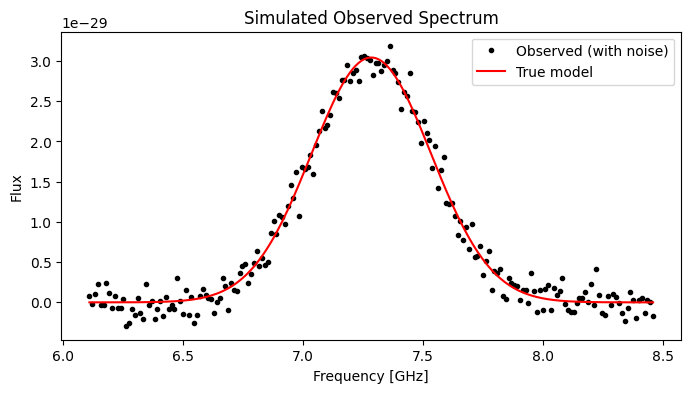

In [3]:
# Create a frequency axis for the line (in Hz)
x = np.linspace(
    nu0_arrayCH3OH[choose_transition] - 2 * fwhm_frequancy, nu0_arrayCH3OH[choose_transition] + 2 * fwhm_frequancy, 200
)
# flux density

flux_density = cloud_metahnol.spectrum(nu=nu0_arrayCH3OH, solid_angle=source_solid_angle)


# Generate the "true" line profile for the chosen transition
flux_amp_true = flux_methanol[choose_transition]
true_spectrum = gaussian(x, flux_amp_true, nu0_arrayCH3OH[choose_transition], fwhm_frequancy)

# Add synthetic noise to mimic observational data (5% noise level)
np.random.seed(42)
noise_std = 0.05 * np.max(true_spectrum)
observed_spectrum = true_spectrum + np.random.normal(0, noise_std, size=x.shape)

# Plot the simulated observed spectrum
plt.figure(figsize=(8, 4))
plt.plot(x / constants.giga, observed_spectrum, "k.", label="Observed (with noise)")
plt.plot(x / constants.giga, true_spectrum, "r-", label="True model")
plt.xlabel("Frequency [GHz]")
plt.ylabel("Flux")
plt.legend()
plt.title("Simulated Observed Spectrum")
plt.show()

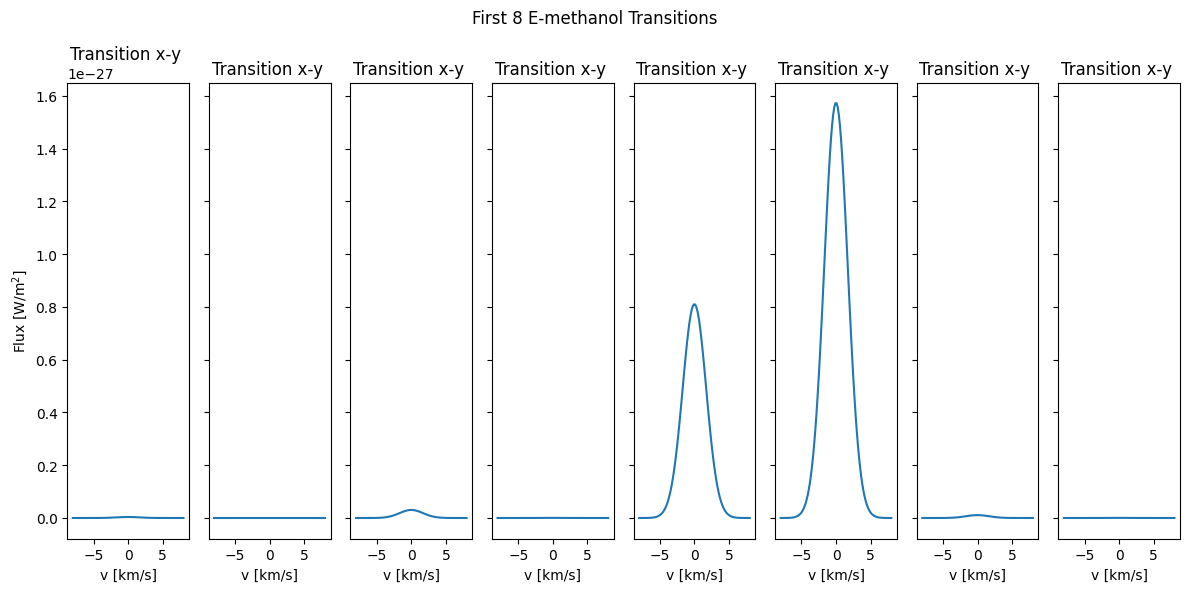

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(12, 6), sharey=True)
fig.suptitle("First 8 E-methanol Transitions")

v = np.linspace(-2 * width_v, 2 * width_v, 100)  # Velocity range in m/s

for i in range(8):
    nu0 = nu0_arrayCH3OH[i]  # Rest frequency of transition i
    nu = nu0 * (1 - v / constants.c)  # Convert frequency to velocity

    # Calculate Gaussian profile
    fwhm = nu0 * (width_v / constants.c)
    spectrum = gaussian(nu, flux_methanol[i], nu0, fwhm)

    ax = axes[i]
    ax.plot(v / constants.kilo, spectrum)
    ax.set_title(f"Transition x-y ")
    ax.set_xlabel("v [km/s]")
axes[0].set_ylabel(r"Flux [W/m$^2$]")

fig.tight_layout()
plt.show()

In [5]:
def model_spectrum(x, params):
    """
    Create spectrum, sum of Gaussians.

    Parameters:
        x: array-like, the independent variable (e.g., wavelength)
        params: list or array of parameters. For n Gaussians, params should be of length 3*n,
                where each Gaussian has [amp, cen, fwhm] in order.

    Returns:
        The sum of Gaussians evaluated at x.
    """
    n_gauss = len(params) // 3
    total = np.zeros_like(x)
    for i in range(n_gauss):
        amp = params[3 * i]
        cen = params[3 * i + 1]
        fwhm = params[3 * i + 2]
        total += gaussian(x, amp, cen, fwhm)
    return total

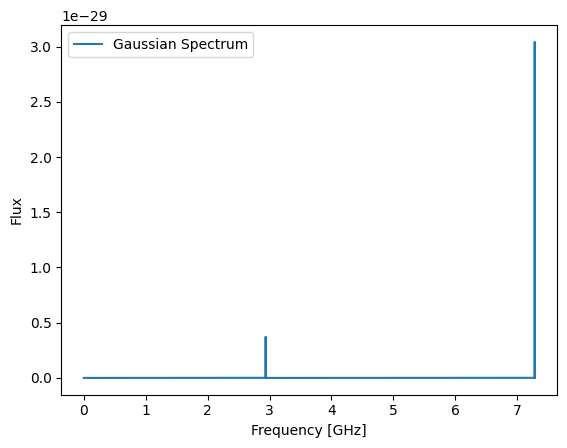

In [6]:
# arbitarry fwhm, use
fwhm_frequency = nu0_arrayCH3OH[choose_transition] * (width_v / constants.c)

# generate frequancy space
x = np.linspace(0, nu0_arrayCH3OH[choose_transition] + 2 * fwhm_frequency, int(1e7))
params = []
for i in range(firstN_transitions):
    # fwhm_frequency = nu0_arrayCo[i] * 0.1
    params.extend([flux_methanol[i], nu0_arrayCH3OH[i], fwhm_frequency])

# Generate the spectrum
spectrum = model_spectrum(x, params)

# Plot the spectrum
fig, ax = plt.subplots()
plt.plot(x / constants.giga, spectrum, label="Gaussian Spectrum")
plt.xlabel("Frequency [GHz]")
plt.ylabel("Flux")
plt.legend()
plt.show()

# Define the MCMC model functions

In [7]:
# Our free parameters are:
#   theta = [Tkin, width_v, log10(n_H2)]
# where n_H2 will be reconstructed from 10**(log_n_H2) / constants.centi**3


def simulate_spectrum_from_params(Tkin_candidate, width_v_candidate, log_n_H2_candidate):
    """Simulate a spectrum from a single transition for a given set of parameters"""

    # Convert log-density to linear density (matching your units)
    n_H2_candidate = 10 ** (log_n_H2_candidate) / constants.centi**3
    # Create a new cloud with the candidate width_v
    cloud_candidate = radiative_transfer.Cloud(
        datafilepath=datafilepath_methanol,
        geometry=geometry,
        line_profile_type=line_profile_type,
        width_v=width_v_candidate,
    )
    cloud_candidate.update_parameters(
        N=N,
        Tkin=Tkin_candidate,
        collider_densities={"H2": n_H2_candidate},
        ext_background=ext_background,
        T_dust=T_dust,
        tau_dust=tau_dust,
    )
    cloud_candidate.solve_radiative_transfer()
    # Get the flux for the chosen transition
    flux_candidate = cloud_candidate.fluxes_of_individual_transitions(
        transitions=[choose_transition], solid_angle=source_solid_angle
    )

    print("flux of spectrum ", flux_candidate)

    # Build the model line using the same Gaussian profile (center and fwhm_frequancy fixed)
    model_line = gaussian(x, flux_candidate, nu0_arrayCH3OH[choose_transition], fwhm_frequancy)
    return model_line


In [8]:
# bobo = simulate_spectrum_from_params(120, 2 * constants.kilo, 8.0)
# # bobo

In [9]:
# # plot the spectrum
# plt.figure(figsize=(8, 4))
# plt.plot(x / constants.giga, bobo, "r-", label="Model")
# plt.xlabel("Frequency [GHz]")
# plt.ylabel("Flux")
# plt.legend()
# plt.title("Model Spectrum")
# plt.show()

# Define log_likelihood, log_prior and log_probability


In [10]:
# Define the log-likelihood function assuming Gaussian errors
def log_likelihood(theta, x, y, yerr):
    amplitude, center, width = theta
    model = gaussian(x, amplitude, center, width)
    log_likelihood_value = -0.5 * np.sum(((y - model) / yerr) ** 2)
    return log_likelihood_value


def log_likelihood_radex(theta, x, y, yerr):
    Tkin_candidate, width_v_candidate, log_n_H2_candidate = theta
    print(f"Evaluating log_likelihood with theta: {theta}")
    model = simulate_spectrum_from_params(Tkin_candidate, width_v_candidate, log_n_H2_candidate)
    log_likelihood_value = -0.5 * np.sum(((y - model) / yerr) ** 2)
    print(f"log_likelihood: {log_likelihood_value}")
    return log_likelihood_value


# Define the log-prior (set ranges to include the true values)
def log_prior(theta):
    Tkin_candidate, width_v_candidate, log_n_H2_candidate = theta
    if 100 < Tkin_candidate < 150 and 1950 < width_v_candidate < 2050 and 7.8 < log_n_H2_candidate < 8.2:
        return 0.0
    return -np.inf


# def log_prior(theta):
#     Tkin_candidate, width_v_candidate, log_n_H2_candidate = theta
#     if 50 < Tkin_candidate < 300 and 1000 < width_v_candidate < 3000 and 5 < log_n_H2_candidate < 10:
#         return 0.0
#     return -np.inf


# Combine to form the full log-probability function
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [11]:
# reset sampler to zero
samples = []
pos = []

# Initial guess for the parameters [Tkin, width_v, log10(n_H2)]
initial = np.array([140, 2050, 8.1])
ndim = len(initial)
nwalkers = 15

# Define noise levels for each parameter
noise_levels = np.array([1, 10, 0.01])  # Adjust these values as needed

# Initialize walkers in a small Gaussian ball around the initial guess
pos = initial + noise_levels * np.random.randn(nwalkers, ndim)

# Initialize walkers in a small Gaussian ball around the initial guess
# pos = initial + 1 * np.random.randn(nwalkers, ndim)

print("Running MCMC... (this may take a while)")
nsteps = 2000
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, observed_spectrum, noise_std))
with tqdm(total=nsteps, desc="MCMC Sampling", unit="step") as pbar:
    for result in sampler.sample(pos, iterations=nsteps, progress=False):  # Disable emcee's built-in progress bar
        pbar.update(1)  # Update tqdm progress bar

# Discard burn-in and flatten the chain
burnin = int(0.3 * nsteps)
samples = sampler.get_chain(discard=burnin, flat=True)
print("Mean parameter estimates [Tkin, width_v, log10(n_H2)]:")
print(np.mean(samples, axis=0))


# Create a corner plot for the posterior samples
fig_corner = corner.corner(samples, labels=["Tkin", "width_v", "log10(n_H2)"], truths=[Tkin, width_v, 8.0])
plt.show()

# Plot the best-fit model vs the observed spectrum
Tkin_best, width_v_best, log_n_H2_best = np.median(samples, axis=0)
model_best = simulate_spectrum_from_params(Tkin_best, width_v_best, log_n_H2_best)

# print the best fit parameters
print(f"Best fit parameters: Tkin = {Tkin_best}, width_v = {width_v_best}, log10(n_H2) = {log_n_H2_best}")


plt.figure(figsize=(8, 4))
plt.plot(x / constants.giga, observed_spectrum, "k.", label="Observed")
plt.plot(x / constants.giga, model_best, "b-", label="Best-fit model")
plt.xlabel("Frequency [GHz]")
plt.ylabel("Flux")
plt.legend()
plt.title("Best-fit Spectrum vs Observed")
plt.show()

# Plot trace plots for each parameter
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Tkin", "width_v", "log10(n_H2)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("Step number")
plt.show()


Running MCMC... (this may take a while)


MCMC Sampling:   0%|          | 0/2000 [00:00<?, ?step/s]

emcee: Exception while calling your likelihood function:
  params: [ 141.05380205 2036.22330632    8.09062175]
  args: (array([0.00000000e+00, 7.28515186e+02, 1.45703037e+03, ...,
       7.28514967e+09, 7.28515040e+09, 7.28515113e+09]), array([ 7.55904200e-31, -2.09703111e-31,  9.85774891e-31,  2.31723449e-30,
       -3.55005583e-31, -3.54716783e-31,  2.40348341e-30,  1.16926427e-30,
       -7.11440451e-31,  8.28318478e-31, -7.00943177e-31, -7.03608415e-31,
        3.73728473e-31, -2.90289106e-30, -2.61493477e-30, -8.44947487e-31,
       -1.52805127e-30,  4.92790096e-31, -1.36313472e-30, -2.12652774e-30,
        2.25467966e-30, -3.12806750e-31,  1.39110144e-31, -2.12359993e-30,
       -7.76643613e-31,  2.29379093e-31, -1.67889498e-30,  6.55737610e-31,
       -8.14383011e-31, -3.27427445e-31, -7.79187472e-31,  2.97574064e-30,
        1.64239912e-31, -1.39395327e-30,  1.49989334e-30, -1.56882473e-30,
        6.49971922e-31, -2.59771897e-30, -1.58028340e-30,  8.03517076e-31,
        1.699

Traceback (most recent call last):
  File "C:\Users\alios\OneDrive - University College London\Desktop\UCL\Year3\PHAS0056_Machine_Learning\emcee\src\emcee\ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\alios\AppData\Local\Temp\ipykernel_30080\3180821252.py", line 38, in log_probability
    return lp + log_likelihood(theta, x, y, yerr)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\alios\AppData\Local\Temp\ipykernel_30080\3180821252.py", line 5, in log_likelihood
    log_likelihood_value = -0.5 * np.sum(((y - model) / yerr) ** 2)
                                           ~~^~~~~~~
ValueError: operands could not be broadcast together with shapes (200,) (10000000,) 
MCMC Sampling:   0%|          | 0/2000 [00:00<?, ?step/s]


ValueError: operands could not be broadcast together with shapes (200,) (10000000,) 

In [ ]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]

array([ 141.75037101, 2032.68469121,    8.08999725])